In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn import MSELoss, Sequential, Linear, Sigmoid, Tanh, ReLU, ELU, Softmax
import torch.nn.functional as F
import torch.nn as nn
from torch import Tensor
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.nn.utils import clip_grad_norm_
import random
import matplotlib.ticker as ticker
from my_sol_helper import *
%matplotlib inline

In [3]:
confusion = np.load('confusion_file.npy')
confusion

array([[23.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 1., 21.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., 29.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  1., 35.,  0.,  0.,  3.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., 16.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., 21.,  1.,  0.,  0.,  0.],
       [ 1.,  2.,  1.,  1.,  1.,  0., 17.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  1.,  0.,  0., 24.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  2.,  0., 12.,  9.],
       [ 0.,  3.,  0.,  0.,  3.,  1.,  0.,  3.,  0., 15.]])

accuracy: 0.8452380952380952


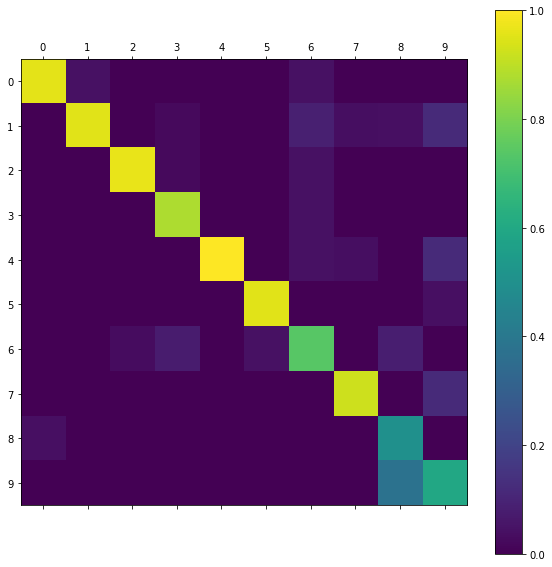

In [5]:
all_categories = [str(x) for x in range(10)]
pr = 0
for i in range(10):
    pr += confusion[i][i]

print('accuracy:', pr/confusion.sum())
for i in range(10):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.transpose())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [2]:
train_dataset = GraphEmbDataset(graph_file='graph2vec/data/train_graphs', num_neighbors = 4)

# test_dataset = GraphEmbDataset(graph_file='graph2vec/data/test_graphs', num_neighbors = 4)

In [3]:
class graph2vec(nn.Module):
    
    def __init__(self, num_neighbors, n_hidden, n_categories, num_eigenvectors, net_hidden, 
                 num_features = 4, num_classes = 10, center_eigenvectors = True, abs_eigenvectors = True):
        super(graph2vec, self).__init__()
        self.num_neighbors = num_neighbors
        self.n_hidden = n_hidden
        self.rnn = RNN(num_features, n_hidden, n_categories)
        self.num_eigenvectors = num_eigenvectors
        self.net = FCNet(n_categories * num_eigenvectors, net_hidden, num_classes)
        self.center_eigenvectors = center_eigenvectors
        self.abs_eigenvectors = abs_eigenvectors
        
    def forward(self, t):
        hidden = self.rnn.initHidden(t.shape[0])
        for i in range(t.shape[1]):
            output, hidden = self.rnn(t[:,i,:], hidden)
        n = PCA_svd(output, g2v.num_eigenvectors, center=self.center_eigenvectors)#['components']
        if self.abs_eigenvectors:
            com, expv = n['components'], n['explained_variance']
            n = torch.mul(expv, com.t()).t()
        else:
            n = n['components']
        out = self.net.forward(n.reshape((1, -1)).float())
        return out
    
    def test(self, t):
        with torch.no_grad():
            hidden = self.rnn.initHidden(t.shape[0])
            for i in range(t.shape[1]):
                output, hidden = self.rnn(t[:,i,:], hidden)
            n = PCA_svd(output, g2v.num_eigenvectors, center=True)#['components']
            com, expv = n['components'], n['explained_variance']
            n = torch.mul(expv, com.t()).t()
            out = self.net.forward(n.reshape((1, -1)).float())
        return out 

In [4]:
class graph2vec_next(nn.Module):
    
    def __init__(self, rnn, n_categories, num_classes = 10):
        super(graph2vec_next, self).__init__()
        self.rnn = rnn
        self.without_PCA_linear = nn.Linear(n_categories, 15)
        self.without_PCA_linear2 = nn.Linear(15, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, t):
        hidden = self.rnn.initHidden(t.shape[0])
        for i in range(t.shape[1]):
            output, hidden = self.rnn(t[:,i,:], hidden)
        
        x = torch.mm(output.type_as(self.PCA_substitute), self.PCA_substitute).max(0)[0]
        x = self.without_PCA_linear(x.float()).reshape((-1, 15))
        x = F.relu(x)
        x = nn.Dropout()(x)
        x = self.without_PCA_linear2(x)
        return self.softmax(x)
        
    def test(self, t):
        with torch.no_grad():
            hidden = self.rnn.initHidden(t.shape[0])
            for i in range(t.shape[1]):
                output, hidden = self.rnn(t[:,i,:], hidden)

            x = torch.mm(output.type_as(self.PCA_substitute), self.PCA_substitute).max(0)[0]
            x = self.without_PCA_linear(x.float()).reshape((-1, 15))
            x = F.relu(x)
            x = nn.Dropout()(x)
            x = self.without_PCA_linear2(x)
            out = self.softmax(x)
        return out

In [5]:
def get_eigenvectors(model, train_dataset, n_categories, counter):
    evg_vectors = [torch.zeros((model.num_eigenvectors, n_categories), 
                                       dtype=torch.float64)] * 10
    with torch.no_grad():
        for indx in range(len(train_dataset)):
            t, l = train_dataset.__getitem__(indx)
            if len(t) <= 5:
                continue
                
            hidden = torch.zeros(t.shape[0], model.n_hidden)
            for i in range(t.shape[1]):
                output, hidden = model.rnn(t[:,i,:], hidden)

            n = PCA_svd(output, model.num_eigenvectors, center=True)#['components']
            com, expv = n['components'], n['explained_variance']
            n = torch.mul(expv, com.t()).t()
            
            evg_vectors[l] = evg_vectors[l] + n
        for i, coun in enumerate(counter):
            evg_vectors[i] = evg_vectors[i] / coun
    
    PCA_substitute = torch.cat(evg_vectors, 0)
    PCA_substitute.requires_grad_(requires_grad = False)
    return PCA_substitute

## Распределение по классам

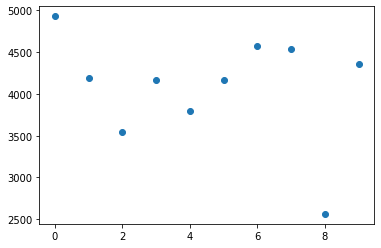

In [6]:
counter = np.zeros(10)
for i in range(len(train_dataset)):
    graph, clas = train_dataset.__getitem__(i)
    if len(graph) > 5:
        counter[clas] +=1

plt.scatter(y = counter, x = np.arange(10))

## центрир_векоторов, есть домнож на СЧ, транспонирование

In [7]:
batch_size = 128
num_neighbors = 3
n_hidden = 6
n_categories = 30
num_eigenvectors = 3
net_hidden = 20
# grads = [[]] * 8

5 from 5: 42752it [01:40, 424.98it/s]                           


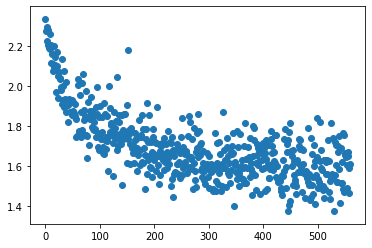

In [13]:
g2v = graph2vec(num_neighbors, n_hidden, n_categories, num_eigenvectors, net_hidden, 
                center_eigenvectors = True, abs_eigenvectors = True)

loss = nn.CrossEntropyLoss(weight=Tensor(counter.sum() / counter))
optimizer = optim.Adagrad(g2v.parameters(), lr=0.3)

running = True
while running:
    try:
        losses = train(g2v, train_dataset, batch_size, 5, optimizer, loss)
        running = False
    except RuntimeError :
        pass
    

plt.scatter(range(len(losses)), losses)

100%|██████████| 42743/42743 [01:07<00:00, 636.17it/s] 


accuracy: 0.4626989958363948


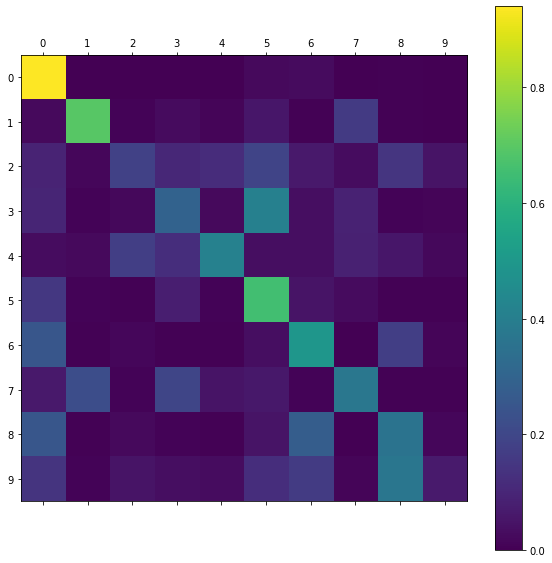

In [14]:
showHeatMap(g2v, train_dataset)

100%|██████████| 42743/42743 [00:53<00:00, 792.67it/s] 


accuracy: 0.4589762429586089


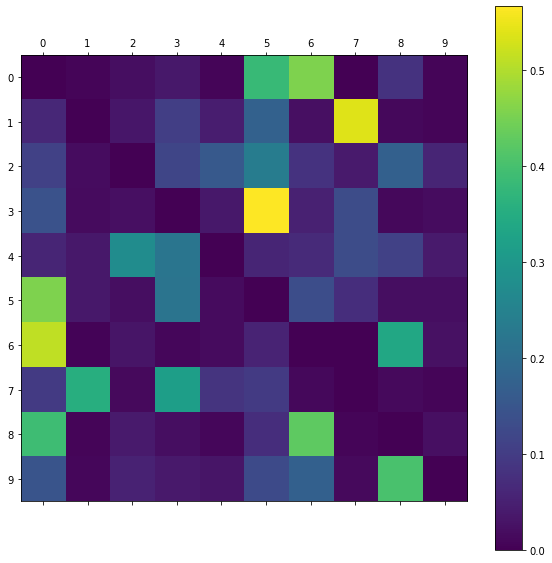

In [15]:
showHeatMap(g2v, train_dataset, background = True)

In [23]:
weights = [] # weights g2v after first learning
for param in g2v.rnn.parameters():
    weights.append(param.clone())

10 from 10: 42752it [00:42, 998.23it/s]                            


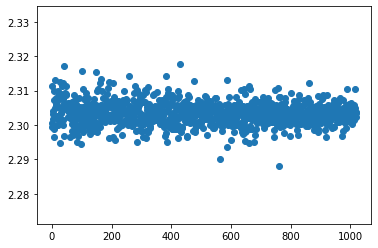

In [25]:
g2v_next = graph2vec_next(g2v.rnn, n_categories)

PCA_substitute = get_eigenvectors(g2v, train_dataset, n_categories, counter)

g2v_next.PCA_substitute = torch.inverse(PCA_substitute.t()) / 1000

optimizer = optim.Adagrad(g2v_next.parameters(), lr=0.4)
losses = train(g2v_next, train_dataset, batch_size, 10, optimizer, loss)

plt.scatter(range(len(losses[100:])), losses[100:])

100%|██████████| 42743/42743 [00:21<00:00, 1975.16it/s]


accuracy: 0.10671075189811413


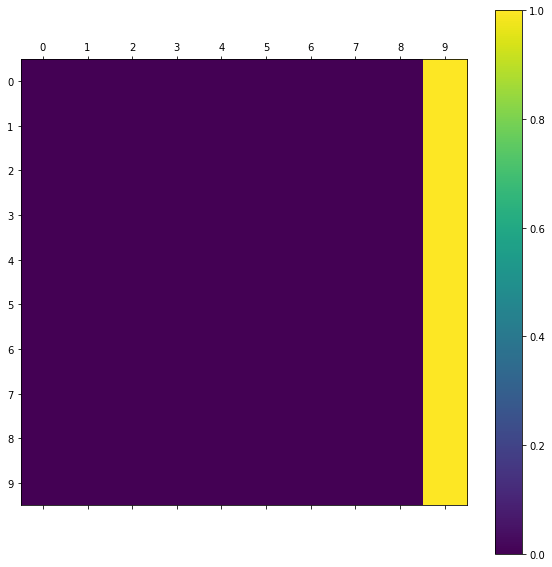

In [26]:
showHeatMap(g2v_next, train_dataset)

100%|██████████| 42743/42743 [00:21<00:00, 1948.84it/s]


accuracy: 0.10673524369336272


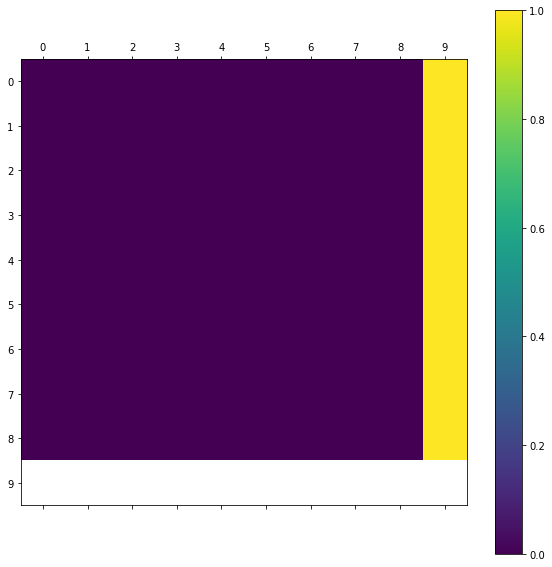

In [27]:
showHeatMap(g2v_next, train_dataset, background = True)

## Save and load